# **Архитектуры свёрточных сетей**

**Цель задания:** изучить работу с готовыми моделями из библиотеки torchvision.

1) **Загрузим датасет EMNIST из torchvision.**

In [ ]:
!pip install torch torchvision matplotlib

In [ ]:
# ставим последнюю совместимую версию с драйвером и проверяем
conda install pytorch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 pytorch-cuda=12.4 -c pytorch -c nvidia

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt

In [2]:
# Проверка доступности CUDA (GPU)
print(torch.__version__)  # Версия PyTorch
print(torch.cuda.is_available())  # True, если GPU доступен
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))  # Имя вашего GPU
else:
    print("CUDA is not available. Please install the NVIDIA driver.")

2.4.0
True
NVIDIA GeForce RTX 3070 Laptop GPU


In [3]:
# Определение устройства для обучения (GPU, если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Функция для выбора оптимального преобразования для каждой модели
def get_transform(model_name):
    if model_name == 'inception_v3':
        # Для Inception v3 используем изображения размером 299x299
        return transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((299, 299)),
            transforms.ToTensor()
        ])
    else:
        # Для всех остальных моделей используем изображения 224x224
        return transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

2) **Обучим на нём модели: ResNet 18, VGG 16, Inception v3, DenseNet 161:**

In [5]:
# Определение моделей и модификация выходных слоев для 27 классов
def get_model(name):
    if name == 'resnet18':
        model = torchvision.models.resnet18(weights=None)  
        model.fc = nn.Linear(model.fc.in_features, 27)
    elif name == 'vgg16':
        model = torchvision.models.vgg16(weights=None)  
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 27)
    elif name == 'inception_v3':
        model = torchvision.models.inception_v3(weights=None) 
        model.fc = nn.Linear(model.fc.in_features, 27)
    elif name == 'densenet161':
        model = torchvision.models.densenet161(weights=None) 
        model.classifier = nn.Linear(model.classifier.in_features, 27)
    return model.to(device)

In [6]:
from torch.amp import autocast, GradScaler

In [7]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=2):
    model.train()
    scaler = GradScaler('cuda')  # Указываем устройство явно
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Обнуление градиентов
            optimizer.zero_grad()

            # Прямой проход в режиме смешанной точности
            with autocast('cuda'):  # Явно указываем устройство
                outputs = model(inputs)

                # Проверка, возвращает ли модель Inception v3 два выхода
                if isinstance(outputs, torchvision.models.inception.InceptionOutputs):
                    # Для Inception v3: Основной и вспомогательный выход
                    loss1 = criterion(outputs.logits, labels)
                    loss2 = criterion(outputs.aux_logits, labels)
                    loss = loss1 + 0.4 * loss2  # Взвешиваем вспомогательный выход
                else:
                    # Для всех остальных моделей
                    loss = criterion(outputs, labels)

            # Обратный проход с использованием скейлера
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Сохранение лосса
            running_loss += loss.item()

        # Очищаем кеш GPU
        torch.cuda.empty_cache()

        # Средний лосс за эпоху
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    return train_losses


In [8]:
# Модели для обучения
models = ['resnet18', 'vgg16', 'inception_v3', 'densenet161']
model_losses = {}

In [9]:
# Обучение каждой модели
for model_name in models:
    print(f"Training {model_name}...")

    # Получаем нужные преобразования для модели
    transform = get_transform(model_name)

    # Загрузка данных с использованием преобразований
    train_dataset = torchvision.datasets.EMNIST(root='./data', split='letters', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.EMNIST(root='./data', split='letters', train=False, download=True, transform=transform)

    # Увеличиваем количество потоков для параллельной загрузки данных
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8)

    # Получаем модель
    model = get_model(model_name)

    # Определение функции потерь и оптимизатора
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Тренировка модели
    losses = train_model(model, train_loader, test_loader, criterion, optimizer)
    model_losses[model_name] = losses

Training resnet18...
Epoch [1/2], Loss: 0.3311
Epoch [2/2], Loss: 0.1856
Training vgg16...
Epoch [1/2], Loss: 3.3192
Epoch [2/2], Loss: 3.2587
Training inception_v3...


C:\Users\Yaros\anaconda3\envs\clean_env\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Epoch [1/2], Loss: 0.5235
Epoch [2/2], Loss: 0.3007
Training densenet161...
Epoch [1/2], Loss: 0.3982
Epoch [2/2], Loss: 0.2070


3) **Сведём результаты обучения моделей (графики лосса) в таблицу и сравним их.**

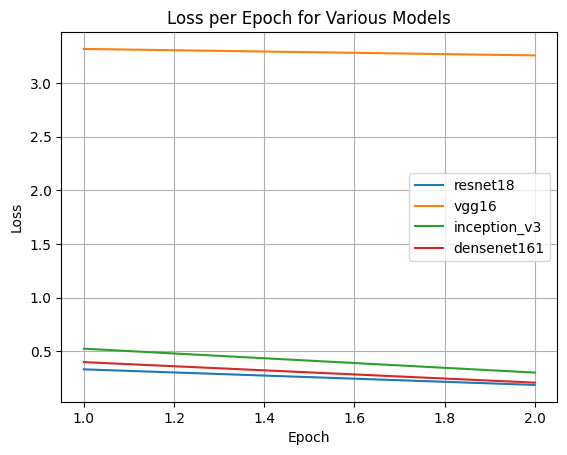

In [13]:
import pandas as pd

# Построение графиков потерь (лосса) для каждой модели
for model_name, losses in model_losses.items():
    plt.plot(range(1, len(losses) + 1), losses, label=model_name)

plt.title('Loss per Epoch for Various Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Создание таблицы с результатами потерь
loss_data = pd.DataFrame(model_losses)

# Отображение таблицы
print("Таблица потерь по моделям (Loss per Epoch for each Model):")
print(loss_data)

Таблица потерь по моделям (Loss per Epoch for each Model):
   resnet18     vgg16  inception_v3  densenet161
0  0.331068  3.319200      0.523527     0.398242
1  0.185644  3.258715      0.300670     0.207031


**Выводы:**  
  
- *VGG16 показывает самые высокие потери:*
  * Лосс для VGG16 остаётся на уровне около 3.3 в обеих эпохах, что указывает на то, что модель либо плохо обучается, либо ей требуется больше эпох, чтобы начать показывать хорошие результаты.
  * Высокие потери могут быть следствием сложной архитектуры модели и медленного сходимости, особенно на первых эпохах.  
  
- *Inception v3 и DenseNet161:*
  * Inception v3 и DenseNet161 показывают схожие результаты в плане уменьшения потерь. Оба лосса начали снижаться после первой эпохи.  
  * Лосс Inception v3 снизился с 0.5235 до 0.3007, а у DenseNet161 с 0.3982 до 0.2070. Это указывает на то, что обе модели достаточно эффективно обучаются, но DenseNet161 показывает более быструю сходимость (более низкий лосс во второй эпохе).  
  
- *ResNet18:*
  * ResNet18 также показывает хорошие результаты с небольшими потерями. Лосс снизился с 0.3311 до 0.1856, что делает его конкурентом DenseNet161 в плане сходимости.
  * Модель ResNet18 сходит быстрее, чем VGG16, и показывает стабильную динамику уменьшения потерь.

**О чём это говорит:**  

- VGG16 требует больше времени для сходимости. Её обучение на данном этапе идёт медленно, и модель может показывать высокие потери на ранних стадиях.  
- ResNet18, Inception v3 и DenseNet161 демонстрируют лучшие результаты, причём DenseNet161 и ResNet18 немного опережают Inception v3.
- DenseNet161 и ResNet18 могут оказаться более подходящими моделями для данной задачи, если основной критерий — это быстрая сходимость и низкие потери за короткое время.

**Рекомендации:**  

- Если ресурсы ограничены и важно быстро получить хорошие результаты, стоит продолжить обучение на ResNet18 или DenseNet161, так как они показывают лучшую сходимость на ранних стадиях.
- Если важны конечные результаты и есть возможность подождать, можно продолжить обучение VGG16 или дать ей больше эпох, чтобы увидеть, как она будет вести себя на более поздних этапах.

**Проблематика, с которой я сталкнулся:**  

a) несовместимость версий PYTorch и Cuda;  
b) минимально поддерживаемый параметр transforms.Resize((N, N)) для определённой модели. Для Inception v3 (299, 299). Если указывать данный параметр абсолютно для каждой модели - наблюдалось крайне долгое обучение для VGG16;  
c) Наличие основного и вспомогательного выхода для каждой эпохи в Inception v3;  
d) Для того, чтобы облегчить обучение - сбрасывал кэш после каждой эпохи, уменьшил размер батча и использовал autocast и GradScaler.